In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import time
import random
import itertools
import  matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from behalearn.preprocessing import columns
from behalearn.authentication import authentication_metrics
from behalearn.authentication import authentication_results
from behalearn.estimators import VotingClassifier
from behalearn.features import FeatureExtractor
from behalearn.features import temporal
from behalearn.metrics import fmr_score
from behalearn.metrics import fnmr_score
from behalearn.metrics import eer_score
from behalearn.metrics import hter_score
from behalearn.preprocessing import StartEndSegmentSplitter
from behalearn.preprocessing import SegmentSplitter
from behalearn.preprocessing.segment import criteria
from behalearn.visualization import initialize_notebook_output
from behalearn.visualization import label_touches
from behalearn.visualization import plot_fmr_fnmr
from behalearn.visualization import visualize_mobile_data
from behalearn.visualization import visualize_mouse_data
from behalearn.visualization import visualize_custom_data


In [39]:
segment_column = 'segment'
user_column = 'user'
user_name_column = 'username'
compute_features_for_segment = True
delete_nan_features = True

path_to_raw_data = '../login_datasets/2019-01-08_FIIT_-2-poschodie_po_skuske_KPAIS_correct_patterns_only/'
path_to_featutes = "../login_features/" + ("segments" if compute_features_for_segment else "paterns") + ("" if delete_nan_features else "_nan") + "/"

columns_to_identificate_features = ['id', 'pattern_id','device','scenario', user_name_column, user_column]
if compute_features_for_segment:
    columns_to_identificate_features.append(segment_column)


In [ ]:
touch_data = pd.read_csv(path_to_raw_data + 'touch.csv', sep=',')
acc_data = pd.read_csv(path_to_raw_data + 'linear_accelerometer.csv', sep=',')
gyro_data = pd.read_csv(path_to_raw_data + 'gyroscope.csv', sep=',')
touch_data
touch_data["id"] = touch_data["pattern_id"].astype(str) + touch_data["device"]
acc_data["id"] = acc_data["pattern_id"].astype(str) + acc_data["device"]
gyro_data["id"] = gyro_data["pattern_id"].astype(str) + gyro_data["device"]

if compute_features_for_segment:
    touch_data["id"] += touch_data['segment'].astype(str)
    acc_data["id"] += acc_data['segment'].astype(str)
    gyro_data["id"] += gyro_data['segment'].astype(str)
else:
    touch_data.drop('segment', axis=1, inplace=True)
    acc_data.drop('segment', axis=1, inplace=True)
    gyro_data.drop('segment', axis=1, inplace=True)

In [ ]:
touch_data.head()

In [ ]:
le = LabelEncoder()
le.fit(pd.concat([touch_data['id'], acc_data['id'], gyro_data['id']]))
touch_data[user_column] = le.transform(touch_data['id'])
acc_data[user_column] = le.transform(acc_data['id'])
gyro_data[user_column] = le.transform(gyro_data['id'])

In [ ]:
touch_data.head()

In [ ]:
def get_columns_combinations(col_names,combinations = None):
    combs = columns._get_column_combinations(col_names, combinations)
    final_combs=[]
    for comb in combs:
        if len(comb) > 1:
            final_combs.append(comb)
    return final_combs

In [ ]:
def calculate_maginute_to_df(df, columns_name):
    final_combinations = []
    for combination in get_columns_combinations(columns_name):
        sum = [0]*len(df)
        for dimension in combination:
            sum += df[dimension] ** 2
        magnitude=sum **(1/2)
        new_column='_'.join(combination)
        df[new_column]=magnitude
        final_combinations.append(new_column)
        
    return final_combinations

In [ ]:
def compute_features(df, features, prefix = None):
    extractor = FeatureExtractor(features, [user_column])

    features_df = extractor.fit_transform(df)
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    if delete_nan_features:
        features_df = features_df.dropna()
    
    if prefix is not None:
        features_df.columns = features_df.columns.str.replace(r"velocity", prefix)

    return features_df

In [ ]:
def renaming_condition(x, columns_name, prefix):
    if x in columns_name:
        return prefix + x
    return x


def add_prefix_to_columns(df, columns_name, prefix):
    df.columns = [renaming_condition(col, columns_name, prefix) for col in df.columns]

    return [prefix + s for s in columns_name]

In [ ]:
def compute_statistics(df, columns_to_compute_statistic, prefix):
    columns_to_compute_statistic += calculate_maginute_to_df(df, columns_to_compute_statistic)
    columns_to_compute_statistic = add_prefix_to_columns(df, columns_to_compute_statistic, prefix)

    statistics = df.groupby([user_column])[columns_to_compute_statistic].describe()
    statistics.columns = statistics.columns.to_flat_index()
    statistics.rename(columns='_'.join, inplace=True)
    statistics = statistics[statistics.columns.drop(list(statistics.filter(regex='count')))]
    
    return statistics

In [ ]:
def normalize_columns_names(df):
    df.columns = df.columns.str.replace(r"25%", "_lower_q")
    df.columns = df.columns.str.replace(r"50%", "_median")
    df.columns = df.columns.str.replace(r"75%", "_upper_q")
    df.columns = df.columns.str.replace(r"__", "_")

In [ ]:
features = [
    'duration',
    ('length', {
        'columns': ['x', 'y'],
    }),
    ('start', {
        'columns': ['x', 'y'],
    }),
    ('velocity', {
        'columns': ['x', 'y'],
    }),
    ('acceleration', {
        'columns': ['x', 'y'],
    }),
    ('jerk', {
        'columns': ['x', 'y'],
    }),
    ('angular_velocity', {
        'columns': ['x', 'y'],
    }),
    ('angular_acceleration', {
        'columns': ['x', 'y'],
    }),
]
print(time.strftime("%Y-%m-%d %H:%M"))
touch_features = compute_features(touch_data, features)
touch_features = touch_features.merge(touch_data[columns_to_identificate_features], on=[user_column]).drop_duplicates()
features = [
    ('velocity', {
        'columns': ['x', 'y', 'z'],
    }),
]
print(time.strftime("%Y-%m-%d %H:%M"))

acc_features = compute_features(acc_data, features, "accelerometer_jerk")
acc_statistics_from_raw_data = compute_statistics(acc_data,['x','y','z'],"accelerometer_")
acc_features = acc_features.merge(acc_statistics_from_raw_data, on='user', how='inner').drop_duplicates()
print(time.strftime("%Y-%m-%d %H:%M"))

gyro_features = compute_features(gyro_data, features, "gyro_jerk")
gyro_statistics_from_raw_data = compute_statistics(gyro_data,['x','y','z'],"gyro_")
gyro_features = gyro_features.merge(gyro_statistics_from_raw_data, on='user', how='inner').drop_duplicates()
print(time.strftime("%Y-%m-%d %H:%M"))

all_features = touch_features.merge(acc_features, on='user', how='inner').merge(gyro_features, on='user', how='inner')
normalize_columns_names(all_features)

In [ ]:
print(touch_features)
print(acc_features)
print(gyro_features)
print(all_features)

In [ ]:
touch_features.to_csv(path_to_featutes + "touch_feautures.csv", encoding='utf-8', index=False)
acc_features.to_csv(path_to_featutes + "acc_feautures.csv", encoding='utf-8', index=False)
gyro_features.to_csv(path_to_featutes + "gyro_feautures.csv", encoding='utf-8', index=False)
all_features.to_csv(path_to_featutes + "all_feautures.csv", encoding='utf-8', index=False)

In [ ]:
len(touch_data['user'].unique())

In [ ]:
all_features

In [40]:
all_features = pd.read_csv(path_to_featutes + "all_feautures.csv")

In [41]:
all_features = all_features.dropna(thresh=80)
if (user_name_column in columns_to_identificate_features):
    columns_to_identificate_features.remove(user_name_column)
all_features.drop(columns=columns_to_identificate_features, inplace=True)

train_x_columns = [x for x in list(all_features.columns) if x != user_name_column]
train_y_columns = user_name_column

In [ ]:
# scaler = StandardScaler()
# all_features[train_x_columns] = scaler.fit_transform(all_features[train_x_columns])

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(all_features[train_x_columns], all_features[train_y_columns], random_state=42)

In [5]:
def use_knn(df_x_train,df_x_test):
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(df_x_train)
    start = time.time()
    knn=neigh.kneighbors(df_x_test)
    end = time.time()
    return knn

In [ ]:
users= all_features[user_name_column].unique()
print(len(users))
print(users)

In [6]:
def get_threshold_for_knn():
    random_users = random.sample(list(all_features[user_name_column].unique()), 10)
    vsetky_vzdialenosti = []
    for random_user in random_users:
        train = all_features.loc[all_features[user_name_column] == random_user]
        test = all_features.loc[all_features[user_name_column] != random_user]
        knn = use_knn(train[train_x_columns], test[train_x_columns])
        vsetky_vzdialenosti.append(knn[0])
    medians = []
    for hodnota in vsetky_vzdialenosti:
        medians.append(np.percentile(hodnota, 25))  
    
    return np.percentile(medians, 50)
treshold_for_knn = get_threshold_for_knn()
print(treshold_for_knn)
# 33.69773240289701

35.09845772089203


In [7]:
treshold_for_knn=13

In [8]:
def split_to_train_test(df, users_to_train):

    df_shuffled = df.sample(frac=1, random_state=10).reset_index(drop=True)

    mask = [True if x[user_name_column] in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_owner = df_shuffled[mask]

    mask2 = [True if x[user_name_column] not in users_to_train else False for i, x in df_shuffled.iterrows()]
    df_others = df_shuffled[mask2]
    
    df_train = df_owner[:int(len(df_owner)*0.8)]
    df_test = df_owner[int(len(df_owner)*0.8):]
    df_test = df_test.append(df_others[:len(df_test)])
    
    scaler = StandardScaler()
    scaler.fit(df_train[train_x_columns])
    df_train[train_x_columns] = scaler.transform(df_train[train_x_columns])
    df_test[train_x_columns] = scaler.transform(df_test[train_x_columns])
    
    return df_train, df_test

In [9]:
def unify_y_column_format(test_y, predicted, selected_owners, treshold):
    test_converted = [1 if i in selected_owners else 0 for i in test_y]
    
    predict_converted = [1 if i <= treshold else 0 for i in predicted]
    
    return test_converted, predict_converted

In [10]:
def use_imputation(df_train, df_test, train_x_columns):
    imputer = IterativeImputer(random_state=0, max_iter=20, verbose=2)
    imputer.fit(df_train[train_x_columns])
    df_train[train_x_columns] = imputer.transform(df_train[train_x_columns])
    df_test[train_x_columns] = imputer.transform(df_test[train_x_columns])
    return df_train, df_test

In [11]:
def show_results(test_y,predicted_y):
    print ('Accuracy:', accuracy_score(test_y, predicted_y))
    print ('F1 score:', f1_score(test_y, predicted_y, pos_label=1))
    print ('Recall:', recall_score(test_y, predicted_y, pos_label=1))
    print ('Precision:', precision_score(test_y, predicted_y, pos_label=1))
    print ('\n confussion matrix:\n',confusion_matrix(test_y, predicted_y))

In [37]:
def plot_far_eer(test_y_raw, tresholds):

    tresholds, test_y_raw = zip(*sorted(zip(tresholds, test_y_raw)))

    fmr_array=[]
    fnmr_array=[]
    for treshold in tresholds:
        test_y, predicted_y = unify_y_column_format(test_y_raw, tresholds, selected_owners, treshold)

        fmr_array.append(fmr_score(test_y, predicted_y))
        fnmr_array.append(fnmr_score(test_y, predicted_y))

    point = eer_score(list(tresholds), fmr_array, fnmr_array)
    plt.plot(tresholds, fmr_array, 'r') # plotting t, a separately 
    plt.plot(tresholds, fnmr_array, 'b') # plotting t, b separately
    plt.plot(point[0], point[1], marker='o', markersize=5, color="green")
    plt.show()

Accuracy: 0.6161616161616161
F1 score: 0.6122448979591837
Recall: 0.6060606060606061
Precision: 0.6185567010309279

 confussion matrix:
 [[62 37]
 [39 60]]


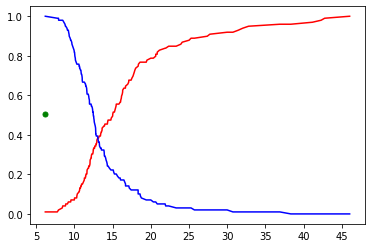

In [38]:
selected_owners = ['mino']
df_train, df_test = split_to_train_test(all_features, selected_owners)

if not delete_nan_features:
    df_train, df_test =  use_imputation(df_train, df_test, train_x_columns)
    
predicted = use_knn(df_train[train_x_columns],df_test[train_x_columns])
tresholds=list(itertools.chain.from_iterable(predicted[0]))

test_y, predicted_y = unify_y_column_format(df_test[train_y_columns], tresholds, selected_owners,treshold_for_knn)

show_results(test_y,predicted_y)

plot_far_eer(df_test[train_y_columns].reset_index(drop=True),tresholds)